**Universidade Federal de Catalão (UFCAT)**  
**Pesquisa de Iniciação Científica (IC) - ciclo 2022 a 2023**  


---
Autores:  
1. Nilson Jorge Leão Júnior (***UFCAT***)  
2. Wanderlei Malaquias Pereira Junior (***UFCAT***)  
3. Antover P. Sarmento (***UFCAT***)  

---
Este *pipeline* gera uma IA treinada para o problema de predição da resistência mecânica à compressão de corpos de prova de argamassa. 

Breve descrição das variáveis:

Atributo           | Unidade   | Nome na coleção               | Sigla
---------          | --------- | ---------                     | -------
Cimento            | kg/m³     | Ci                       | $ci$  
Cal                 | kg/m³     | Ca            | $ca$
Areia Natural      | kg/m³     | NA                      | $Na$
Areia Artificial               | kg/m³     | AR                        | $Ar$
Resíduos de Marmoraria | kg/m³     | RBMG             | $RBMG$
Aditivo Plastificante    | L/m³     | Adi              | $Adi$
Água      | L/m³     | Ag              | $Ag$
Idade              | dias      | Cura                          | $t$  
f_ck               | MPa       | Res | $f_{ck}$


# Etapa de instalação e importações das fontes externas

Instalação de bibliotecas não existentes: 
- ```xlsxwriter```;
- ```openpyxl```;
- ```emoji```;

_Em caso de necessidade de repetidas execuções não é necessário instalar novamente._

Carregando bibliotecas existentes:
- ```IA```;
- ```numpy```;
- ```pandas```;
- ```seaborn```;
- ```sklearn```.

Lista de emojis
https://unicode.org/emoji/charts/emoji-list.html

In [1]:
#!pip install XlsxWriter
#!pip install openpyxl
#!pip install emoji

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter as xw
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from random import randint
import statistics
from math import sqrt
import emoji

In [3]:
# Importação fonte externa
#from IA_COMMON_LIBRARY import *

## **1.1 Carregando o banco de dados do problema**

O banco de dados original foi construído em uma planilha eletrônica de Excel. A planilha agrupo todos os bancos encontrados nesta pesquisa.

In [4]:
# Leitura do dataset
DF_ARGAMASSA = pd.read_excel('dadosres1.xlsx')

DF_ARGAMASSA.head()

,ID.,traço,Ci,Ca,NA,AR,RBMG,Adi,Ag,Cura,Res,Ref,Tipo publi.,Pais,End
0,1,kg/m³,384.3,531.0,2350.0,0.0,0.00,0.0,648.0,28,3.5,"Silva Neto, Brites e Santos (2016)",TCC,BRASIL,https://xdocs.com.br/download/rbmg-argamassa-c...
1,1,kg/m³,384.3,531.0,2230.0,0.0,117.45,0.0,648.0,28,5.0,"Silva Neto, Brites e Santos (2016)",TCC,BRASIL,https://xdocs.com.br/download/rbmg-argamassa-c...
2,1,kg/m³,384.3,531.0,2110.0,0.0,234.40,0.0,648.0,28,6.2,"Silva Neto, Brites e Santos (2016)",TCC,BRASIL,https://xdocs.com.br/download/rbmg-argamassa-c...
3,1,kg/m³,384.3,531.0,2000.0,0.0,352.30,0.0,648.0,28,5.6,"Silva Neto, Brites e Santos (2016)",TCC,BRASIL,https://xdocs.com.br/download/rbmg-argamassa-c...
4,1,kg/m³,384.3,531.0,2350.0,0.0,0.00,0.0,648.0,7,2.5,"Silva Neto, Brites e Santos (2016)",TCC,BRASIL,https://xdocs.com.br/download/rbmg-argamassa-c...


## **1.2 Tratamento dos dados**

### 1.2.1 Limpeza dos dados

Devido as características deste _dataset_ foi criada uma taxa água-cimento ($a/c$), depois eliminou-se a quantidade de água.

In [5]:
DF_TRATADO = DF_ARGAMASSA.copy()

# Execução da limpeza 
DF_TRATADO = DF_TRATADO.drop(columns = 'Ref')
DF_TRATADO = DF_TRATADO.drop_duplicates()

# Criação da coluna relação água cimento (a per c) e eliminação do atributo água ('Ag')
DF_TRATADO['w-c'] = DF_TRATADO['Ag'] / DF_TRATADO['Ci'] 
#Remoção das colunas inúteis para o trabalho
DF_TRATADO = DF_TRATADO.drop(columns = ['Ag','Pais','Tipo publi.','End','traço','ID.'])

first_column = DF_TRATADO.pop('Res')

DF_TRATADO.insert(8, 'Res', first_column)

In [6]:
DF_TRATADO.head()

,Ci,Ca,NA,AR,RBMG,Adi,Cura,w-c,Res
0,384.3,531.0,2350.0,0.0,0.00,0.0,28,1.686183,3.5
1,384.3,531.0,2230.0,0.0,117.45,0.0,28,1.686183,5.0
2,384.3,531.0,2110.0,0.0,234.40,0.0,28,1.686183,6.2
3,384.3,531.0,2000.0,0.0,352.30,0.0,28,1.686183,5.6
4,384.3,531.0,2350.0,0.0,0.00,0.0,7,1.686183,2.5


## **1.3 Descrição do banco de dados**

### 1.3.1 Descrição estatística das variáveis

In [7]:
DF_TRATADO.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ci,370.0,448.748274,300.299055,136.490000,244.108508,450.000000,527.892500,2616.67
Ca,370.0,52.812463,134.457940,0.000000,0.000000,0.000000,0.000000,1338.54
NA,370.0,1197.580206,672.513615,0.000000,945.000000,1320.795000,1534.440000,5273.00
AR,370.0,301.499754,492.883460,0.000000,0.000000,0.000000,426.750000,2250.00
RBMG,370.0,10.348204,38.693430,0.000000,0.000000,0.000000,0.000000,352.30
Adi,370.0,0.388536,1.377766,0.000000,0.000000,0.000000,0.000000,10.60
Cura,370.0,31.875676,33.291693,1.000000,7.000000,28.000000,28.000000,360.00
w-c,370.0,0.919628,0.618938,0.212093,0.500000,0.666667,1.365995,6.00
Res,370.0,20.632080,18.794434,0.540000,5.000000,14.465000,31.875000,76.90


### 1.3.2 Plotagem do histograma das variáveis

['Ci', 'Ca', 'NA', 'AR', 'RBMG', 'Adi', 'Cura', 'w-c', 'Res']


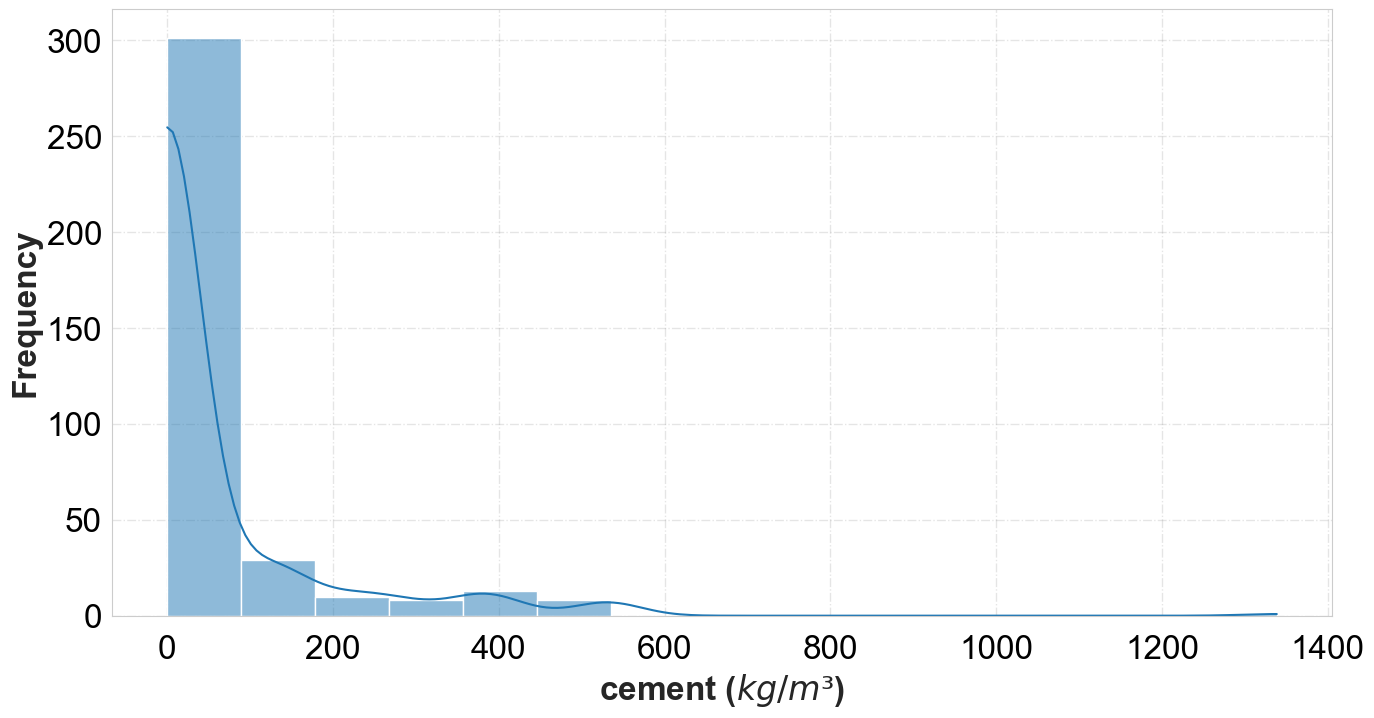

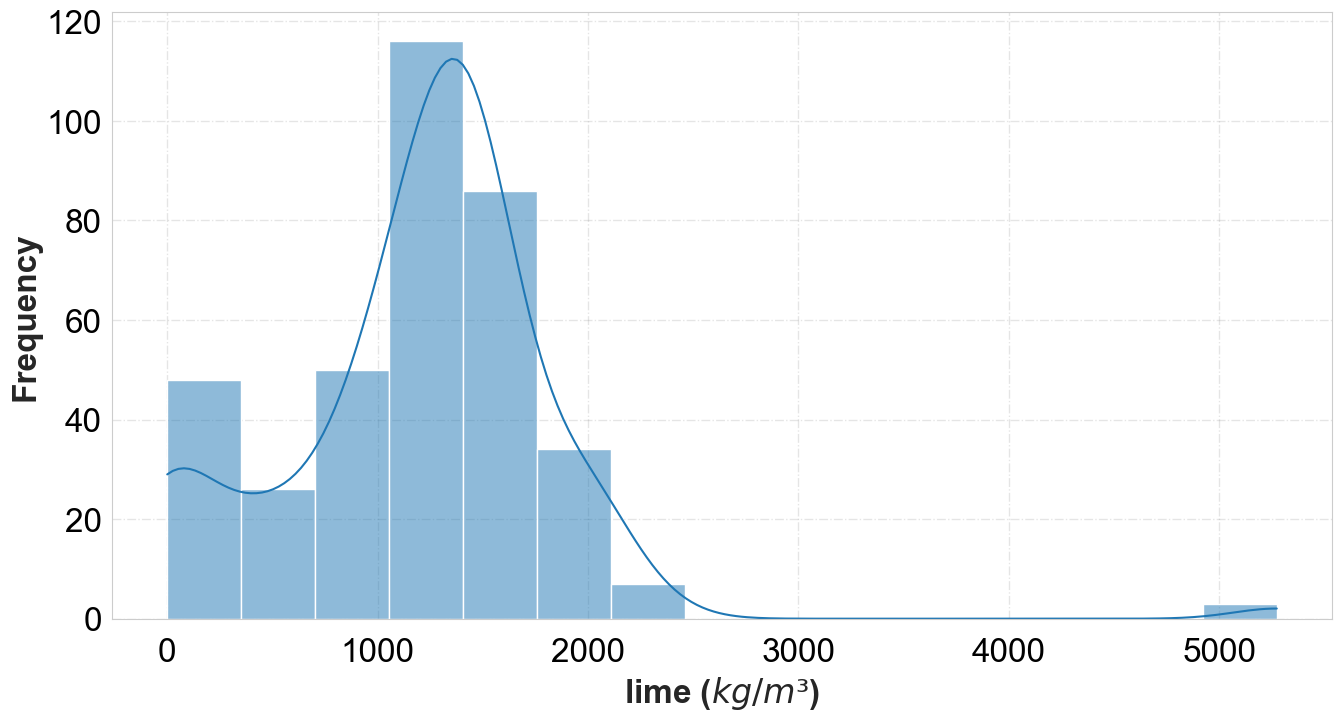

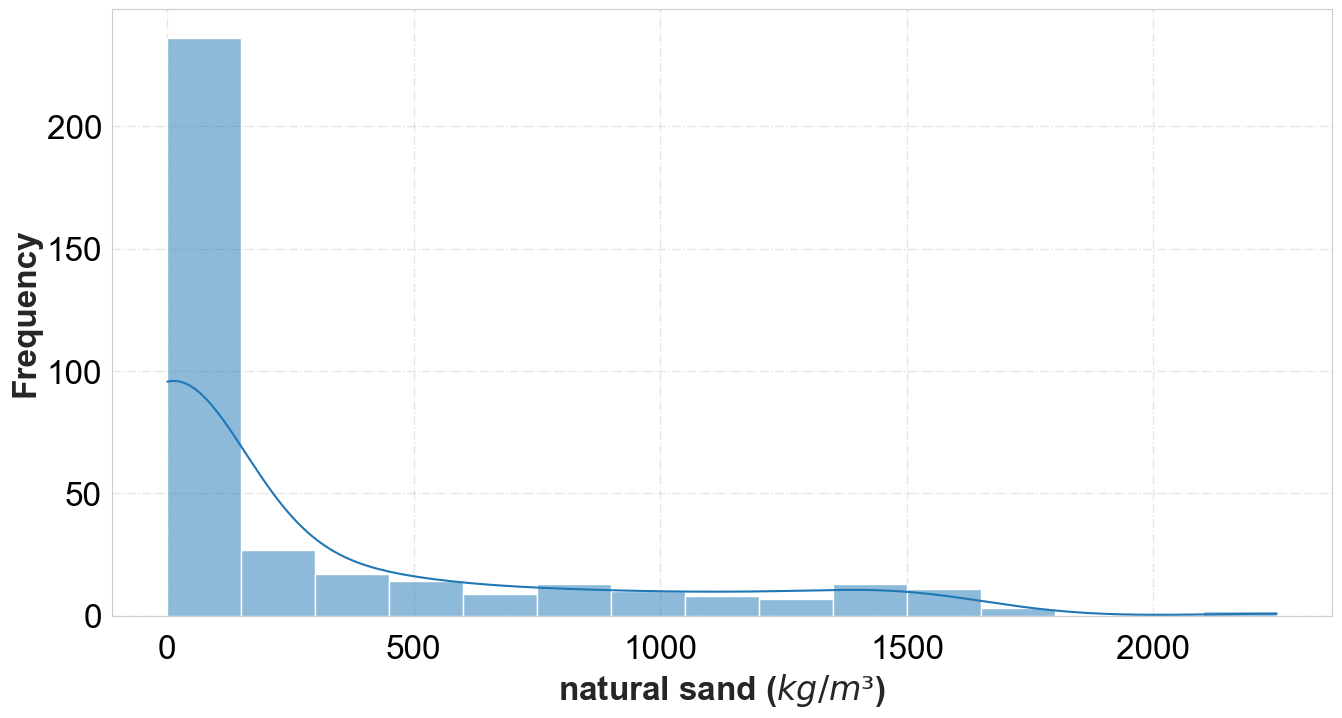

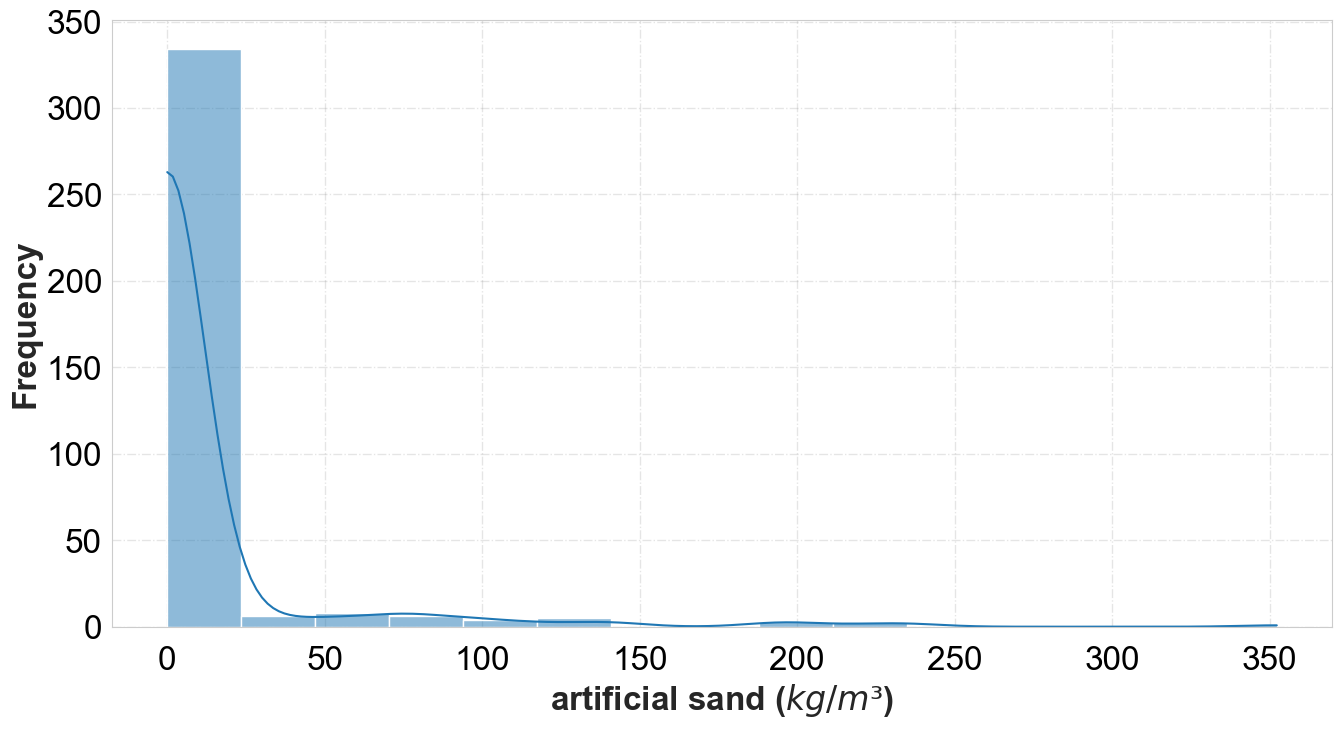

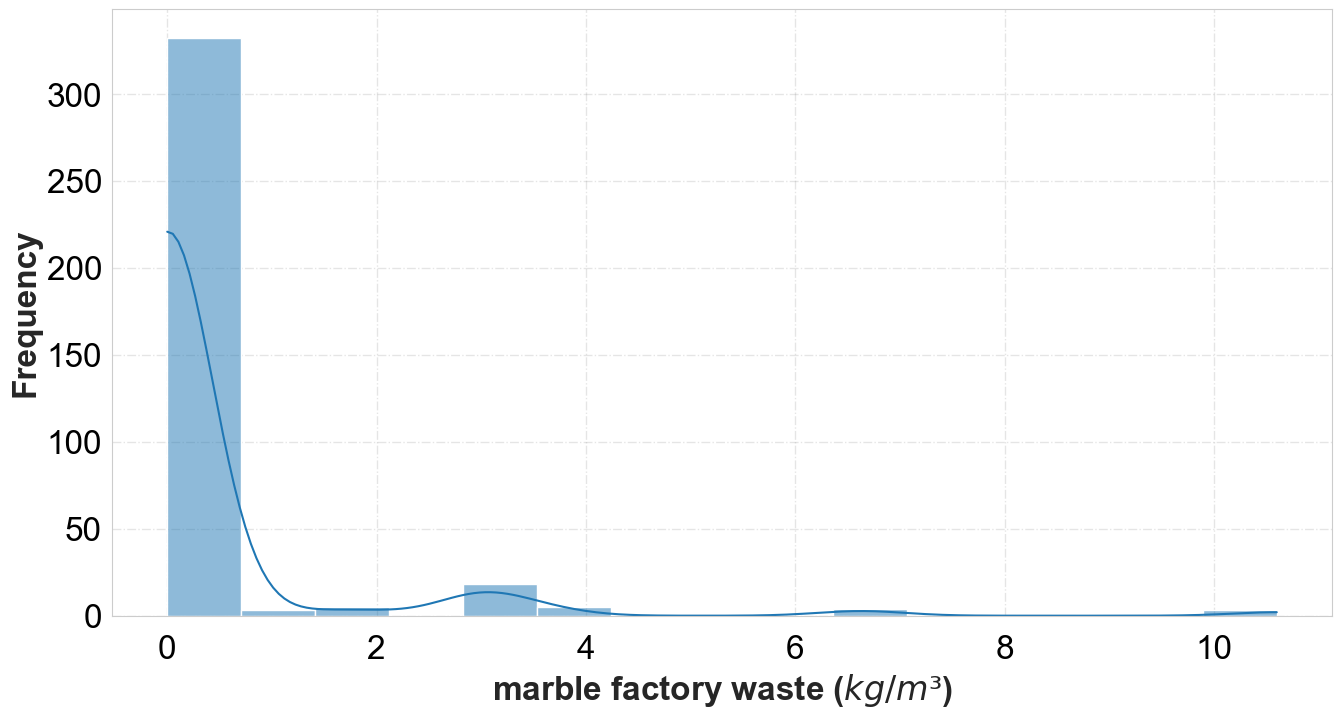

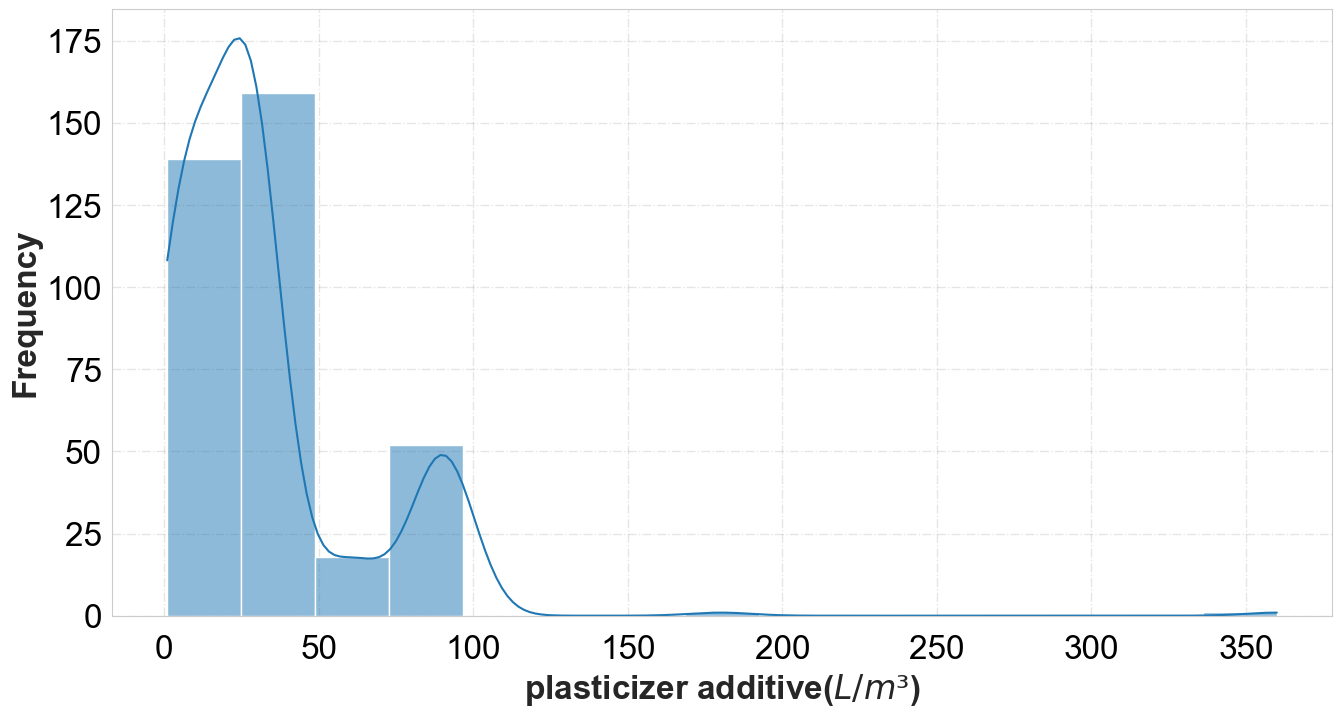

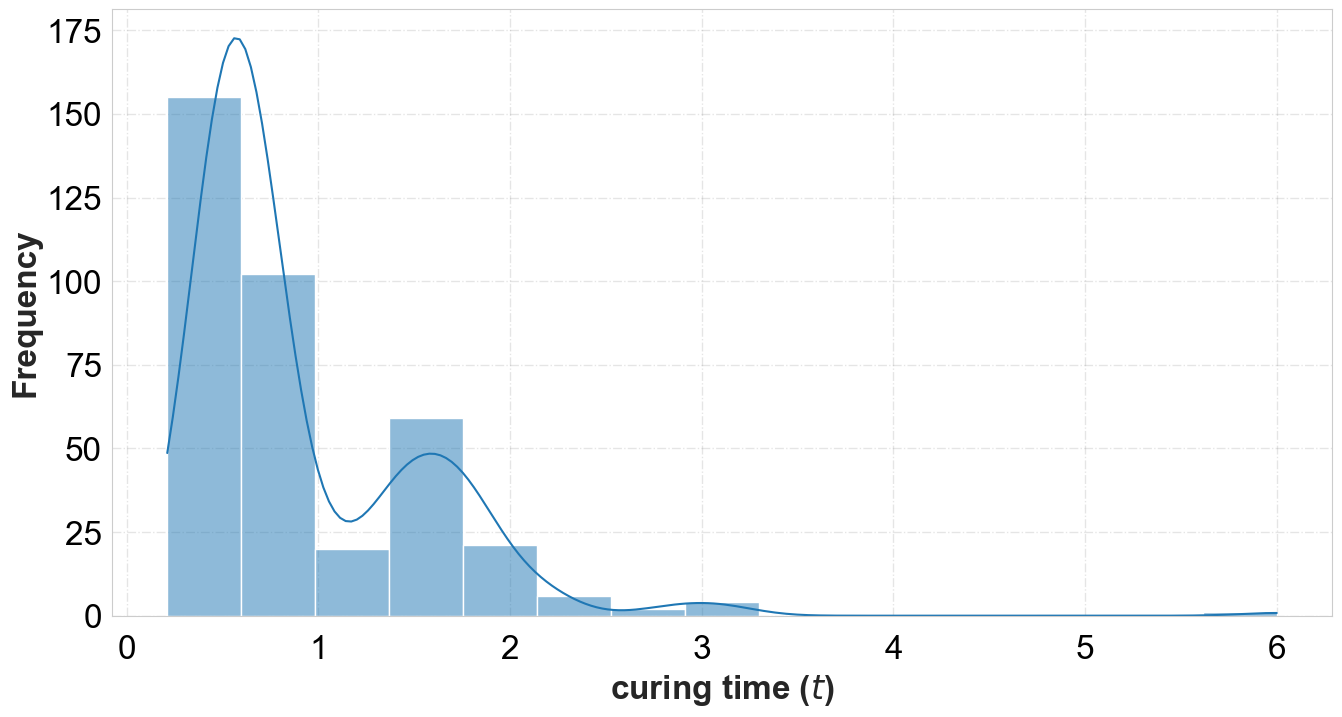

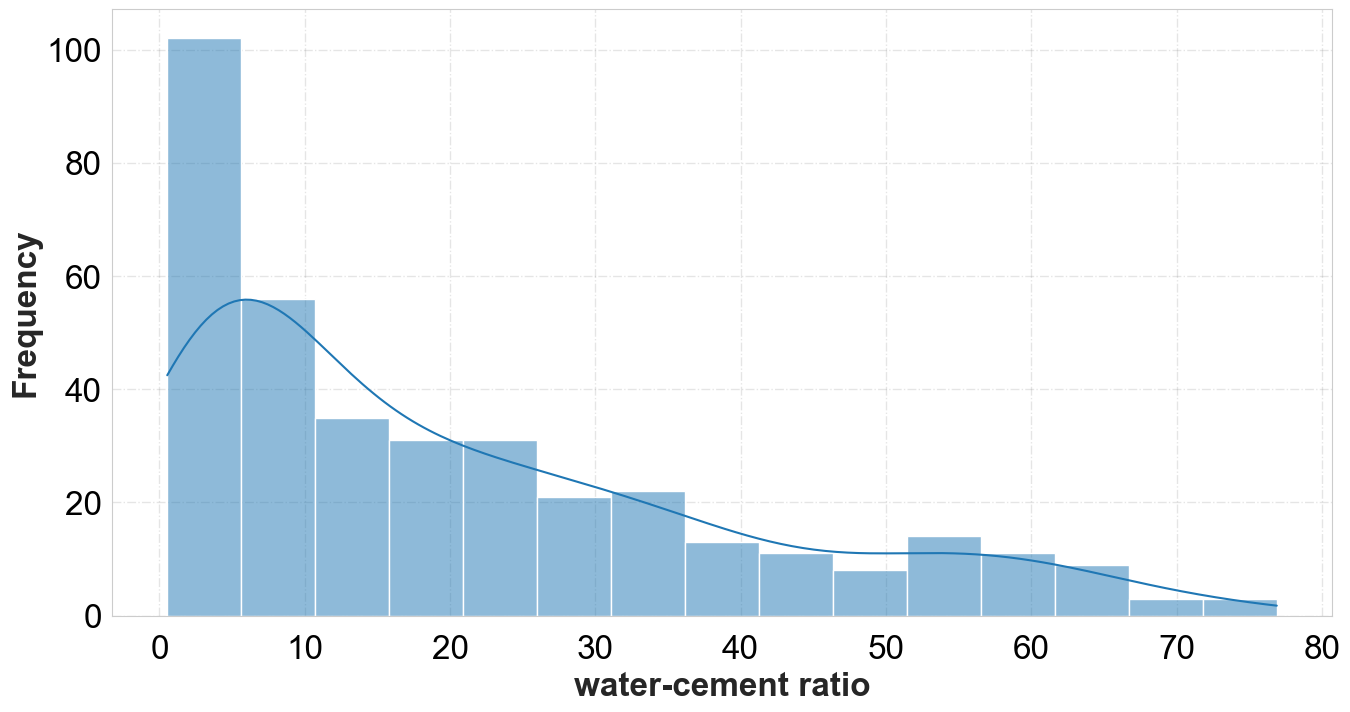

In [8]:
%run Histplot_final.ipynb
LISTA = ['cement ($kg/m³$)', 
         'lime ($kg/m³$)', 
         'natural sand ($kg/m³$)', 
         'artificial sand ($kg/m³$)',
         'marble factory waste ($kg/m³$)',
         'plasticizer additive($L/m³$)',
         'curing time ($t$)',
         'water-cement ratio',
         'Compressive strength ($MPa$)',
        ]

ID = 0

colunas  =  DF_TRATADO.columns.tolist()
print(colunas)
colunas.pop(0)

for COLUMN in colunas:
    #print(COLUMN)
    PLOT_SETUP = {
              'NAME': f'{COLUMN}_hisp',
              'WIDTH': 0.40, 
              'HEIGHT': 0.20,
              'DPI': 600, 
              'EXTENSION': 'jpg',
              'MARKER': 'o',
              'MARKER SIZE': 1.5,
              'Y AXIS LABEL': 'Frequency',
              'X AXIS LABEL': LISTA[ID],
              'LABELS SIZE': 24,
              'LABELS COLOR': '#000000',
              'X AXIS SIZE': 24,
              'Y AXIS SIZE': 24,
              'AXISES COLOR': '#000000',
              'ON GRID?': True,
              'LOC LEGEND': 'upper right',
              'SIZE LEGEND': 14,
              'Y LOG': False,
              'X LOG': False,
              'SMOOTH LINE': True
             }

    DATASET = {'X': DF_TRATADO[COLUMN]}
    
    HISPLOT(DATASET, PLOT_SETUP)
    ID += 1

### 1.3.3 Correlação entre as variáveis

In [9]:

CORRELACAO = DF_TRATADO.corr()
COR = CORRELACAO.unstack().sort_values(kind = 'quicksort', ascending = False)
print(COR[COR != 1].head(20))
print(COR[COR != 1].tail(20))

Res   Ci      0.608592
Ci    Res     0.608592
w-c   Ca      0.520629
Ca    w-c     0.520629
Ci    NA      0.339613
NA    Ci      0.339613
Res   Adi     0.277112
Adi   Res     0.277112
RBMG  Ca      0.265801
Ca    RBMG    0.265801
Res   Cura    0.256595
Cura  Res     0.256595
RBMG  NA      0.249062
NA    RBMG    0.249062
AR    w-c     0.208397
w-c   AR      0.208397
Ci    Cura    0.195311
Cura  Ci      0.195311
NA    Res     0.116000
Res   NA      0.116000
dtype: float64
Adi   w-c    -0.137882
w-c   Adi    -0.137882
Res   RBMG   -0.158555
RBMG  Res    -0.158555
AR    RBMG   -0.164039
RBMG  AR     -0.164039
AR    Ci     -0.218827
Ci    AR     -0.218827
AR    Res    -0.241933
Res   AR     -0.241933
Ci    Ca     -0.273960
Ca    Ci     -0.273960
Res   Ca     -0.347939
Ca    Res    -0.347939
w-c   Ci     -0.489554
Ci    w-c    -0.489554
w-c   Res    -0.528221
Res   w-c    -0.528221
NA    AR     -0.724556
AR    NA     -0.724556
dtype: float64


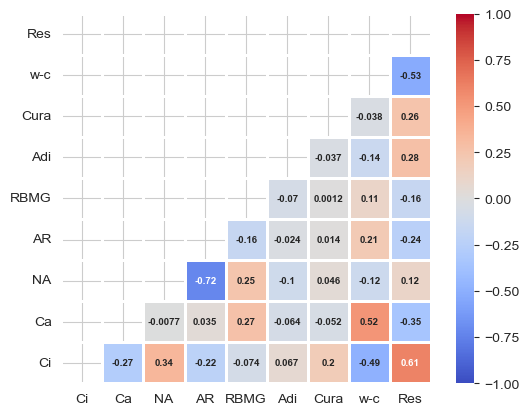

In [10]:
#Plotagem
%run Correlacao.ipynb

PLOT_SETUP = {
              'NAME': 'heatmap_concreto',#
              'WIDTH': 0.40, #
              'HEIGHT': 0.20,#
              'DPI': 600, #
              'EXTENSION': '.jpg',#
              'SQUARE': True,#
              'MASK': True,#
              'ON GRID?': False,#
              'LINE WIDTHS': 0.9,#
              'CMAP': 'coolwarm',#
              'LINE COLOR': 'white',#
              'ANNOT':True,
              'ANNOT SIZE FONT':7,
              'ANNOT FONT WEIGHT':'bold'
             }

DATASET = {'DATA':DF_TRATADO}
HEATMAP(DATASET, PLOT_SETUP)

## **1.4 Padronização dos dados**

Aqui foi empregada a padronização dos dados do tipo **z-score**.

### 1.4.1 Aplicando a escala Z-score

In [11]:
ESCALAS = DF_TRATADO.describe().loc[['mean','std']]
DF_NORMAL = DF_TRATADO.copy()
print(DF_TRATADO)
for COL in DF_NORMAL:
    if COL != 'Res':
        DF_NORMAL[COL] = DF_NORMAL[COL].apply(lambda x: (x - ESCALAS[COL][0]) / ESCALAS[COL][1])    
DF_NORMAL

        Ci     Ca      NA      AR    RBMG  Adi  Cura       w-c   Res
0    384.3  531.0  2350.0     0.0    0.00  0.0    28  1.686183  3.50
1    384.3  531.0  2230.0     0.0  117.45  0.0    28  1.686183  5.00
2    384.3  531.0  2110.0     0.0  234.40  0.0    28  1.686183  6.20
3    384.3  531.0  2000.0     0.0  352.30  0.0    28  1.686183  5.60
4    384.3  531.0  2350.0     0.0    0.00  0.0     7  1.686183  2.50
..     ...    ...     ...     ...     ...  ...   ...       ...   ...
365  189.7   76.6     0.0  1481.0    0.00  0.0    28  1.680548  3.31
366  157.2  127.0     0.0  1577.7    0.00  0.0    28  1.709924  3.22
367  210.6   85.1     0.0  1409.1    0.00  0.0    91  1.600190  4.09
368  189.7   76.6     0.0  1481.0    0.00  0.0    91  1.680548  3.49
369  157.2  127.0     0.0  1577.7    0.00  0.0    91  1.709924  3.36

[370 rows x 9 columns]


,Ci,Ca,NA,AR,RBMG,Adi,Cura,w-c,Res
0,-0.214614,3.556410,1.713601,-0.611706,-0.267441,-0.282004,-0.116416,1.238500,3.50
1,-0.214614,3.556410,1.535166,-0.611706,2.767958,-0.282004,-0.116416,1.238500,5.00
2,-0.214614,3.556410,1.356731,-0.611706,5.790435,-0.282004,-0.116416,1.238500,6.20
3,-0.214614,3.556410,1.193165,-0.611706,8.837464,-0.282004,-0.116416,1.238500,5.60
4,-0.214614,3.556410,1.713601,-0.611706,-0.267441,-0.282004,-0.747204,1.238500,2.50
...,...,...,...,...,...,...,...,...,...
365,-0.862634,0.176914,-1.780752,2.393061,-0.267441,-0.282004,-0.116416,1.229396,3.31
366,-0.970860,0.551753,-1.780752,2.589254,-0.267441,-0.282004,-0.116416,1.276858,3.22
367,-0.793037,0.240131,-1.780752,2.247185,-0.267441,-0.282004,1.775948,1.099564,4.09
368,-0.862634,0.176914,-1.780752,2.393061,-0.267441,-0.282004,1.775948,1.229396,3.49


### 1.4.2 Escala de conversão do _dataset_ original

In [12]:
ESCALAS

,Ci,Ca,NA,AR,RBMG,Adi,Cura,w-c,Res
mean,448.748274,52.812463,1197.580206,301.499754,10.348204,0.388536,31.875676,0.919628,20.632080
std,300.299055,134.457940,672.513615,492.883460,38.693430,1.377766,33.291693,0.618938,18.794434


##  **1.5 Separando os dados em entrada e saída**

Apresentando o conjunto de dados **$x_i$** e **$y(x_i)$**

In [13]:
COLUNA_Y = 'Res'

In [14]:
X = DF_NORMAL.drop(columns = COLUNA_Y)
Y = pd.DataFrame(DF_NORMAL[COLUNA_Y], columns = [COLUNA_Y])

### 1.5.1 Variáveis independentes ($x$)

In [15]:
X.head()

,Ci,Ca,NA,AR,RBMG,Adi,Cura,w-c
0,-0.214614,3.55641,1.713601,-0.611706,-0.267441,-0.282004,-0.116416,1.2385
1,-0.214614,3.55641,1.535166,-0.611706,2.767958,-0.282004,-0.116416,1.2385
2,-0.214614,3.55641,1.356731,-0.611706,5.790435,-0.282004,-0.116416,1.2385
3,-0.214614,3.55641,1.193165,-0.611706,8.837464,-0.282004,-0.116416,1.2385
4,-0.214614,3.55641,1.713601,-0.611706,-0.267441,-0.282004,-0.747204,1.2385


### 1.5.2 Variável dependente ($y$)

In [16]:
Y.head()

,Res
0,3.5
1,5.0
2,6.2
3,5.6
4,2.5


## **1.6 Criação dos modelos de aprendizado de máquina**

Nesta seção será criada uma lista com os modelos de IA que iremos empregar. A posição da lista é formada pelos seguintes fatores:

0. Config modelo;
1. Nome modelo;
2. Validação Cruzada;
3. Treino;
4. Teste;

In [30]:
#para ANN o tanh é ruim como ativação e o sgd é melhor que adam como solver
MODELOS = [
            [LinearRegression(), "Regressão Linear 1°", None, None, None, 'Regressão', 1],
            [LinearRegression(), "Regressão Não Linear 2°", None, None, None, 'Regressão', 2],
            [LinearRegression(), "Regressão Não Linear 3°", None, None, None, 'Regressão', 3],
            [Ridge(), "Regressão Ridge Linear 1°", None, None, None, 'Regressão', 1],
            [Ridge(), "Regressão Ridge Não Linear 2°", None, None, None, 'Regressão', 2],
            [Ridge(), "Regressão Ridge Não Linear 3°", None, None, None, 'Regressão', 3],
            [DecisionTreeRegressor(max_depth = 2), "Árvore de decisão prof 2", None, None, None, 'Árvore', 2],
            [DecisionTreeRegressor(max_depth = 5), "Árvore de decisão prof 5", None, None, None, 'Árvore', 5],
            [DecisionTreeRegressor(max_depth = 10), "Árvore de decisão prof 10", None, None, None, 'Árvore', 10],
            [DecisionTreeRegressor(max_depth = 20), "Árvore de decisão prof 20", None, None, None, 'Árvore', 20],
            [GradientBoostingRegressor(n_estimators = 10, max_depth = 10), "Gradiente Boosting 10 10", None, None, None, 'Ensemble', 10],
            [GradientBoostingRegressor(n_estimators = 50, max_depth = 10), "Gradiente Boosting 50 10", None, None, None, 'Ensemble', 50],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 10), "Gradiente Boosting 100 10", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 20), "Gradiente Boosting 100 20", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 500, max_depth = 20), "Gradiente Boosting 500 20", None, None, None, 'Ensemble', 500],
            [MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', random_state=42), "Neural Network 64 64", None, None, None, 'Network', 1],
            [MLPRegressor(hidden_layer_sizes=(128, 128, 64), activation='relu', solver='adam', random_state=42), "Neural Network 128 128 64", None, None, None, 'Network', 1],
            [MLPRegressor(hidden_layer_sizes=(128, 128, 64), activation='relu', solver='sgd', random_state=42), "Neural Network 128 128 64 sgd", None, None, None, 'Network', 1],
            [MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='sgd', random_state=42), "Neural Network 64 64 sgd", None, None, None, 'Network', 1],
            [MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', random_state=42), "Neural Network 128 64 32", None, None, None, 'Network', 1],
            [MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='sgd', random_state=42), "Neural Network 128 64 32 sgd", None, None, None, 'Network', 1]
          ]

QUANT_MODELOS, _ = np.shape(MODELOS)

## **1.7 Curva de aprendizado para determinação do tamanho da parcela de treino**

## **1.8 Validação cruzada iterativa**

Separação treino e teste

In [18]:
X_TREINO, X_TESTE, Y_TREINO, Y_TESTE  = train_test_split(X, Y, train_size = 0.80, shuffle = True)
Y_TREINO = np.ravel(Y_TREINO)
Y_TESTE = np.ravel(Y_TESTE)

In [31]:
NUM_SEMENTES = 30
SEMENTES = [randint(0, 100) for N in range(NUM_SEMENTES)]

RESULTADOS_VC_SEMENTES = np.zeros((NUM_SEMENTES, QUANT_MODELOS + 1))
ITER = 0

# Validação cruzada com alteração da seed
for I_CONT, SEED in enumerate(SEMENTES):
    # Configuração do Kfold
    KFOLD = KFold(n_splits = 10, shuffle = True, random_state = SEED)   
    
    # Configuração para resultados
    RESULTADOS_VC_SEMENTES[I_CONT, 0] = SEED
    
    # Validação cruzada
    for J_CONT in range(len(MODELOS)):
        # Carregando o modelo
        MODELO = MODELOS[J_CONT][0]
        if MODELOS[J_CONT][5] == 'Regressão':
            GRAU_POLI = MODELOS[J_CONT][6]
            PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
        else:
            PIPELINE = MODELO

        # Validação do modelo
        RESULTADO_VC = cross_val_score(PIPELINE, X_TREINO, Y_TREINO, cv = KFOLD, scoring = "r2", n_jobs = -1)

        # Média dos resultados para uma validação cruzado com n kfolds
        MEDIA_R2VC = np.mean(RESULTADO_VC)

        # Armazenando os resultados
        RESULTADOS_VC_SEMENTES[I_CONT, J_CONT + 1] = MEDIA_R2VC

### 1.8.1 Transformando o _dataset_ de validação cruzada em uma planilha Excel

Estatísticas da validação cruzada

In [32]:
COLUNAS_NOME = ['seed']
for I in range(QUANT_MODELOS):
    COLUNAS_NOME.append(MODELOS[I][1])
RESULTADOS_GERAIS_VC = pd.DataFrame(RESULTADOS_VC_SEMENTES)
RESULTADOS_GERAIS_VC.columns = COLUNAS_NOME
RESULTADOS_GERAIS_VC.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
seed,30.0,5.430000e+01,3.532817e+01,0.000000e+00,2.400000e+01,5.550000e+01,8.750000e+01,9.900000e+01
Regressão Linear 1°,30.0,4.320005e-01,5.391942e-02,2.807152e-01,3.951661e-01,4.523167e-01,4.686499e-01,5.043794e-01
Regressão Não Linear 2°,30.0,-1.323933e+00,7.085328e-01,-2.891485e+00,-1.779613e+00,-1.165800e+00,-7.705038e-01,-3.847805e-01
Regressão Não Linear 3°,30.0,-1.234787e+19,1.593134e+19,-7.598039e+19,-1.303098e+19,-5.631300e+18,-3.897575e+18,-3.981999e+17
Regressão Ridge Linear 1°,30.0,4.346693e-01,5.183738e-02,2.900804e-01,3.976002e-01,4.542715e-01,4.698736e-01,5.052752e-01
Regressão Ridge Não Linear 2°,30.0,3.754715e-01,2.522395e-01,-8.852060e-01,3.370084e-01,4.540579e-01,4.768660e-01,5.360657e-01
Regressão Ridge Não Linear 3°,30.0,-2.115857e+01,2.416333e+01,-1.398430e+02,-1.882676e+01,-1.462694e+01,-1.201423e+01,-1.048347e+01
Árvore de decisão prof 2,30.0,5.478772e-01,2.857192e-02,4.896261e-01,5.310880e-01,5.463270e-01,5.715744e-01,5.943227e-01
Árvore de decisão prof 5,30.0,6.845736e-01,4.017606e-02,6.045476e-01,6.614609e-01,6.820040e-01,7.116717e-01,7.778604e-01
Árvore de decisão prof 10,30.0,7.467656e-01,3.340981e-02,6.679635e-01,7.224837e-01,7.443177e-01,7.779715e-01,8.177143e-01


Salvando os dados da média da validação cruzada iterativa

In [33]:
ESTATISTICA_VC = RESULTADOS_GERAIS_VC.describe().transpose()
for I in range(QUANT_MODELOS):
    MODELOS[I][2] = ESTATISTICA_VC['mean'][I + 1]

Impressão dos dados para teste T

In [34]:
RESULTADOS_GERAIS_VC.to_excel('Validacao cruzada iterativa completa.xlsx', index = False)

## 1.9 Treinamento, teste e teste externo

🎯Modelo: Regressão Linear 1° 
 r^2 acurácia treino: 56.869 
 r^2 acurácia teste: 49.050 



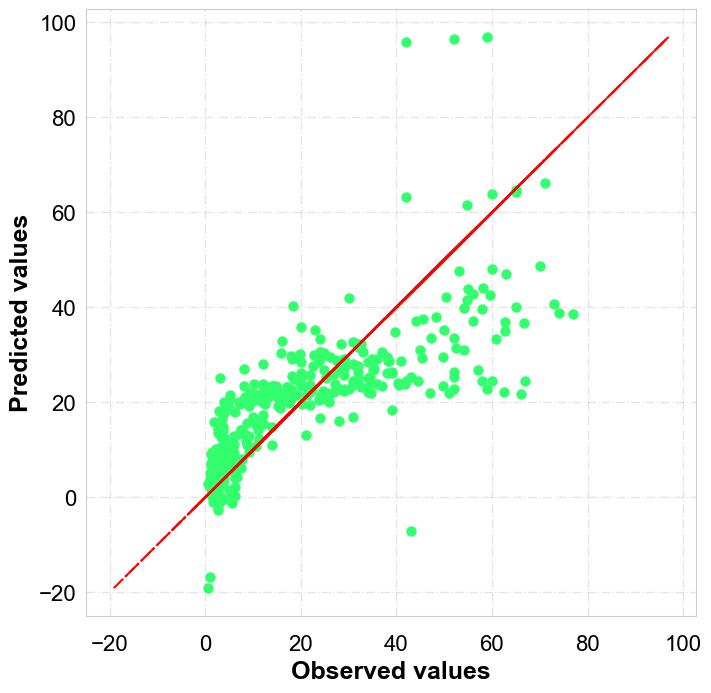

🎯Modelo: Regressão Não Linear 2° 
 r^2 acurácia treino: 61.190 
 r^2 acurácia teste: 31.892 



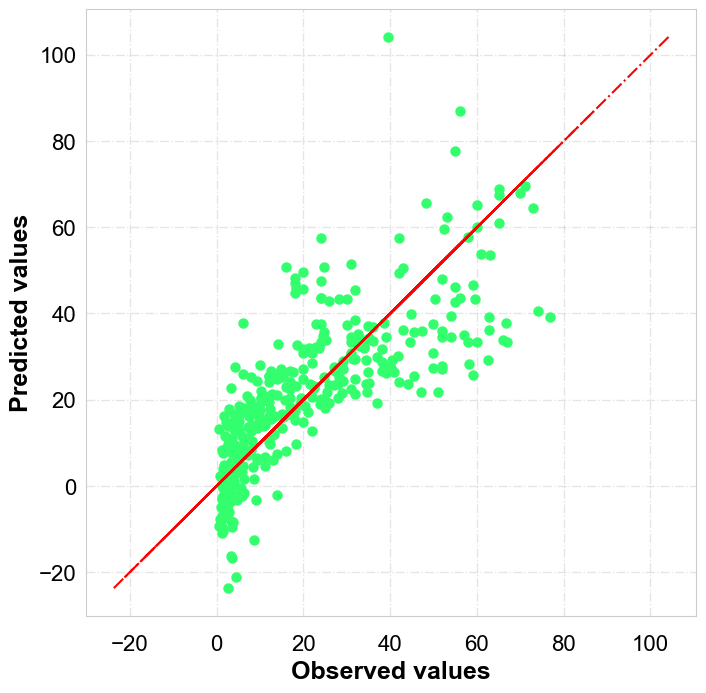

🎯Modelo: Regressão Não Linear 3° 
 r^2 acurácia treino: 89.700 
 r^2 acurácia teste: -404712813189830672384.000 



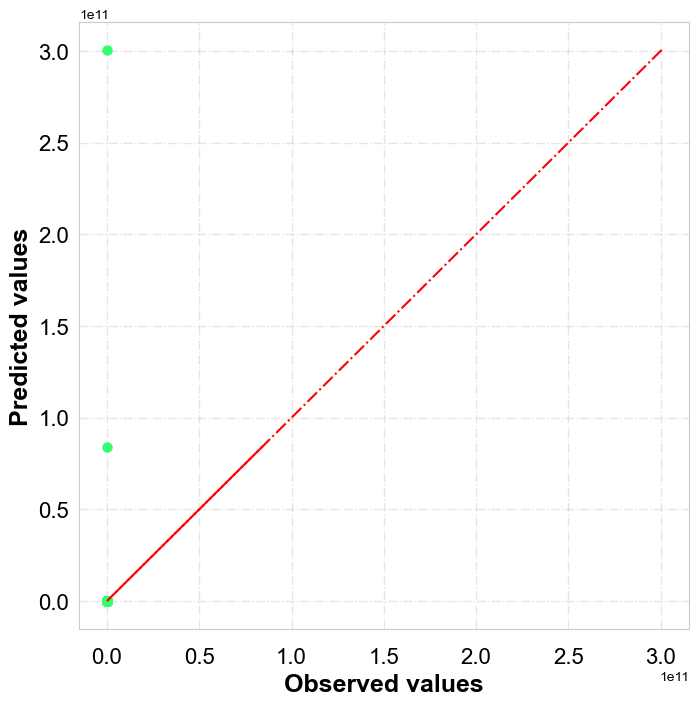

🎯Modelo: Regressão Ridge Linear 1° 
 r^2 acurácia treino: 56.868 
 r^2 acurácia teste: 49.103 



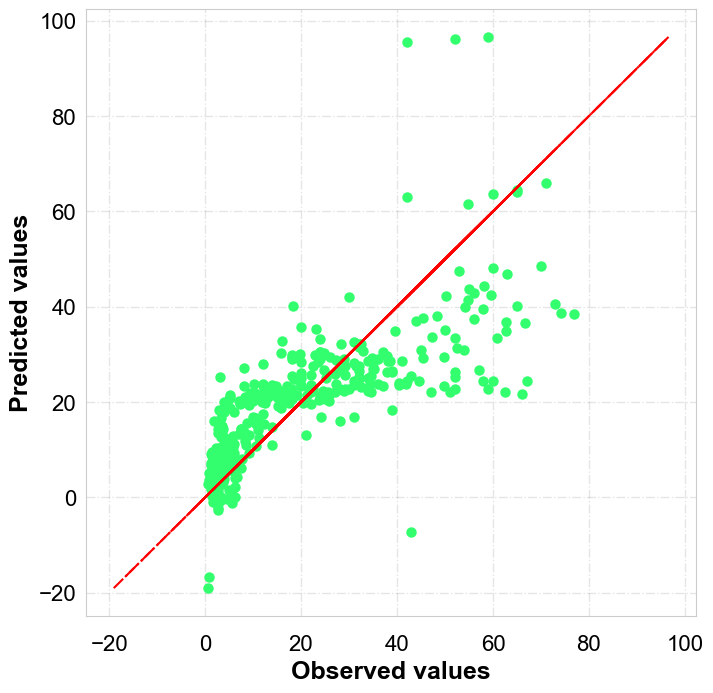

🎯Modelo: Regressão Ridge Não Linear 2° 
 r^2 acurácia treino: 78.583 
 r^2 acurácia teste: 68.401 



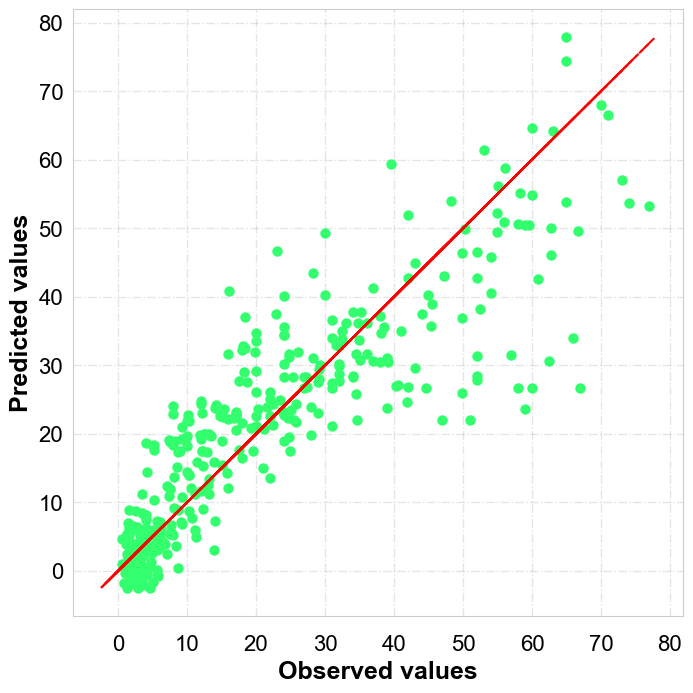

🎯Modelo: Regressão Ridge Não Linear 3° 
 r^2 acurácia treino: 86.599 
 r^2 acurácia teste: 71.149 



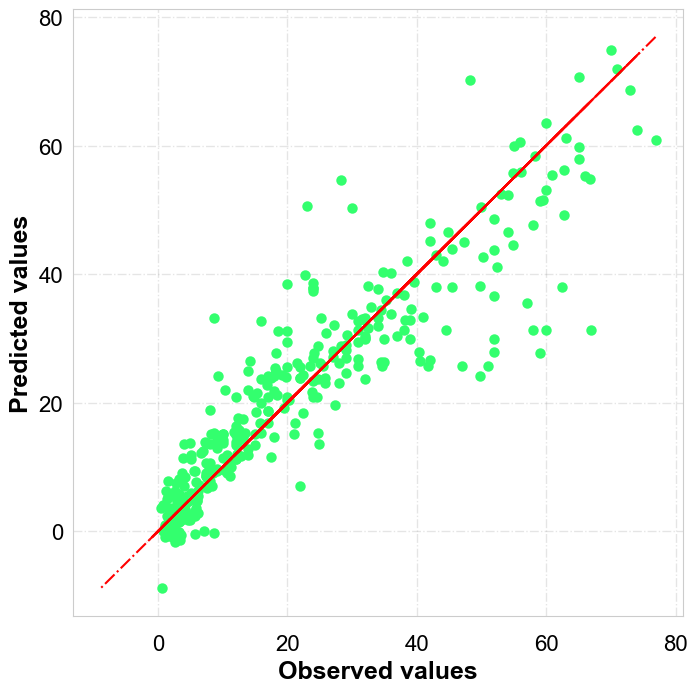

🎯Modelo: Árvore de decisão prof 2 
 r^2 acurácia treino: 64.654 
 r^2 acurácia teste: 63.217 



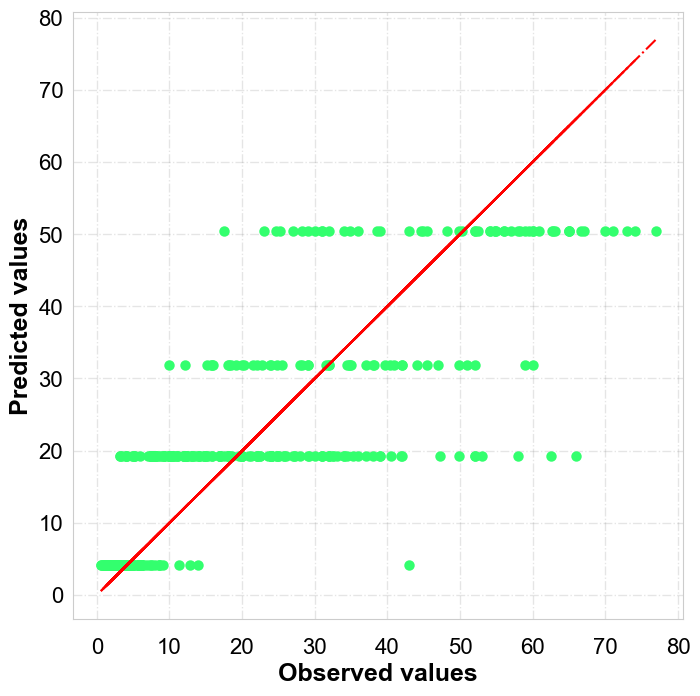

🎯Modelo: Árvore de decisão prof 5 
 r^2 acurácia treino: 85.859 
 r^2 acurácia teste: 74.595 



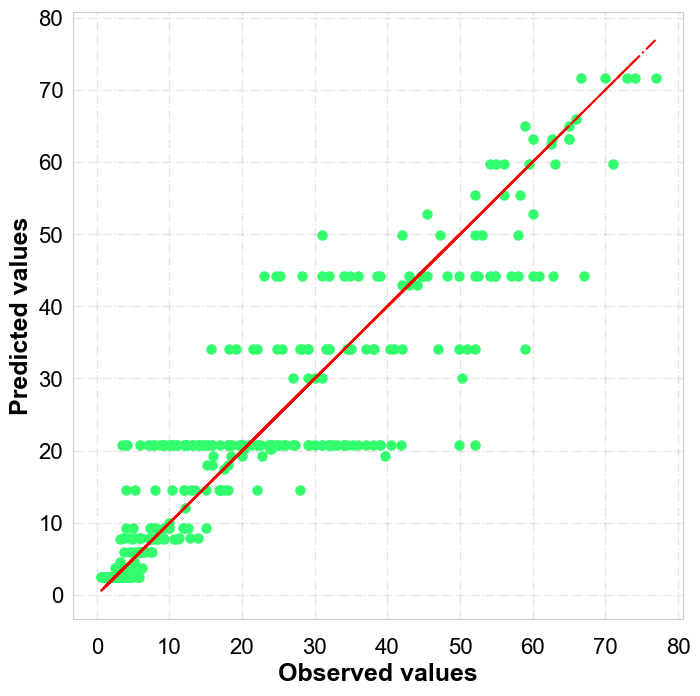

🎯Modelo: Árvore de decisão prof 10 
 r^2 acurácia treino: 98.099 
 r^2 acurácia teste: 73.176 



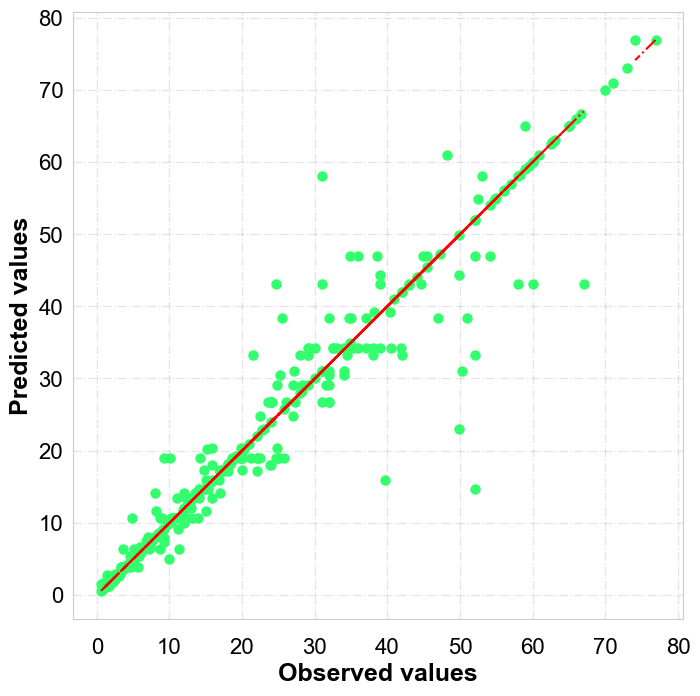

🎯Modelo: Árvore de decisão prof 20 
 r^2 acurácia treino: 99.200 
 r^2 acurácia teste: 73.510 



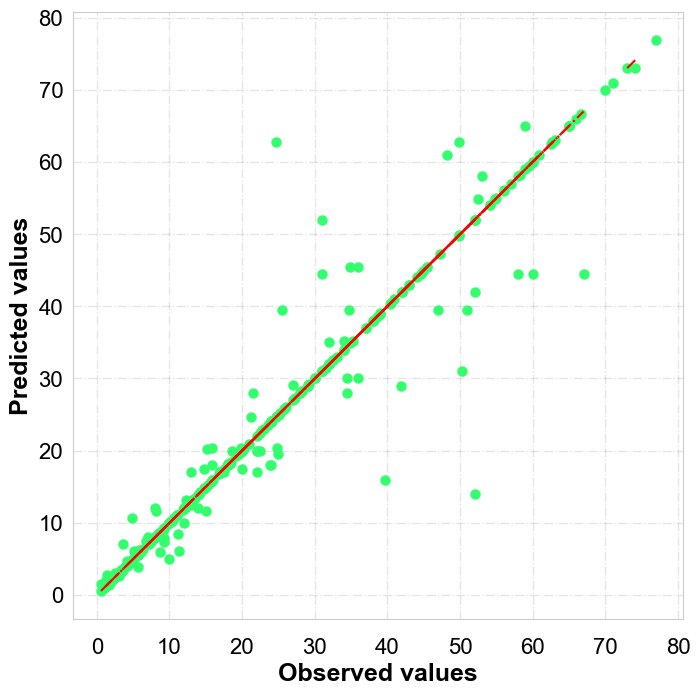

🎯Modelo: Gradiente Boosting 10 10 
 r^2 acurácia treino: 86.842 
 r^2 acurácia teste: 73.106 



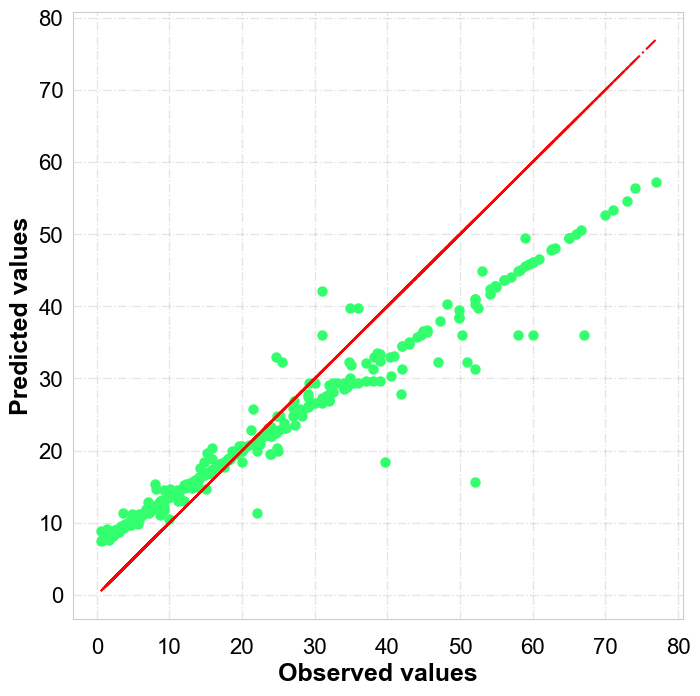

🎯Modelo: Gradiente Boosting 50 10 
 r^2 acurácia treino: 99.193 
 r^2 acurácia teste: 80.808 



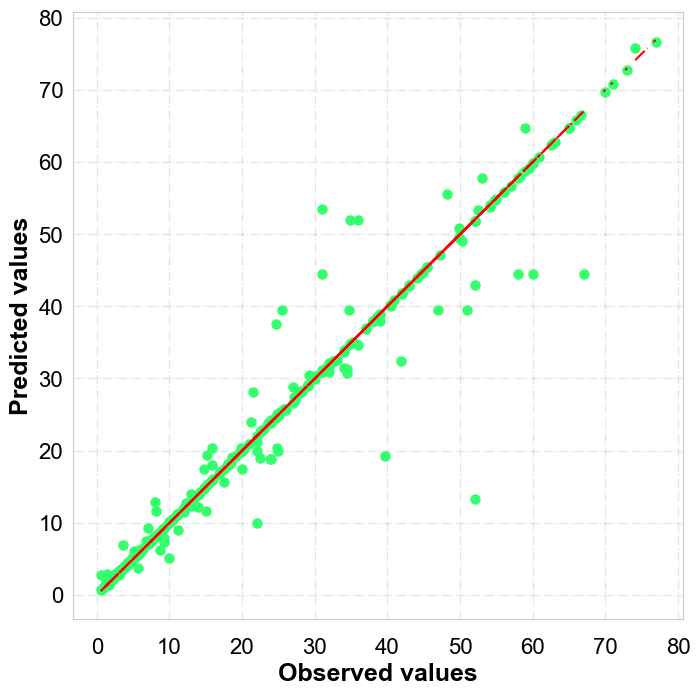

🎯Modelo: Gradiente Boosting 100 10 
 r^2 acurácia treino: 99.200 
 r^2 acurácia teste: 80.765 



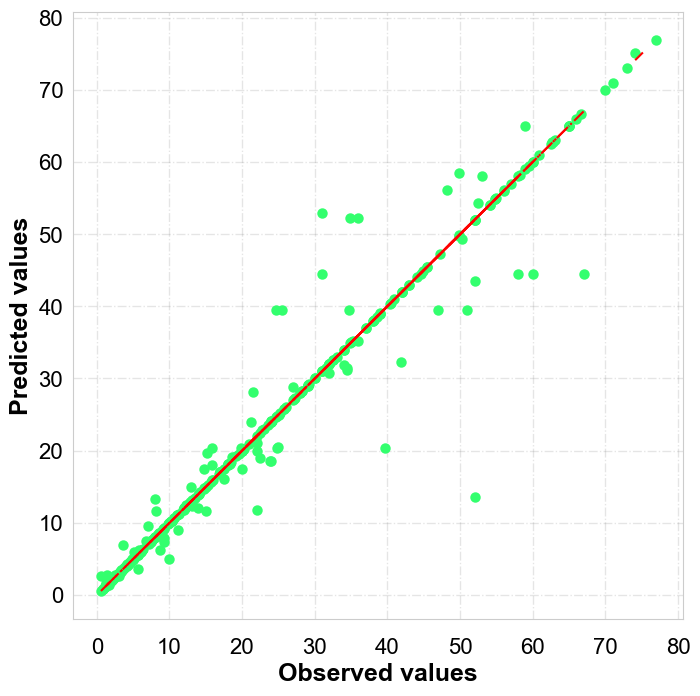

🎯Modelo: Gradiente Boosting 100 20 
 r^2 acurácia treino: 99.200 
 r^2 acurácia teste: 76.830 



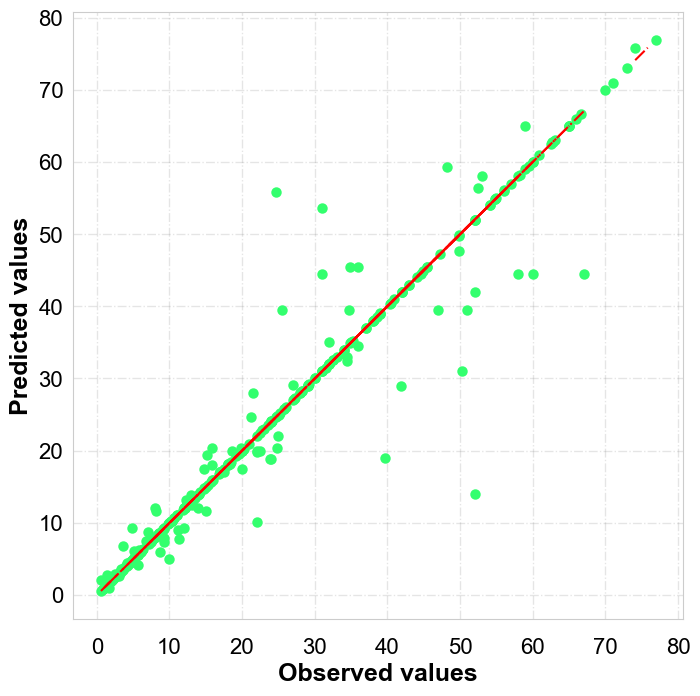

🎯Modelo: Gradiente Boosting 500 20 
 r^2 acurácia treino: 99.200 
 r^2 acurácia teste: 77.168 



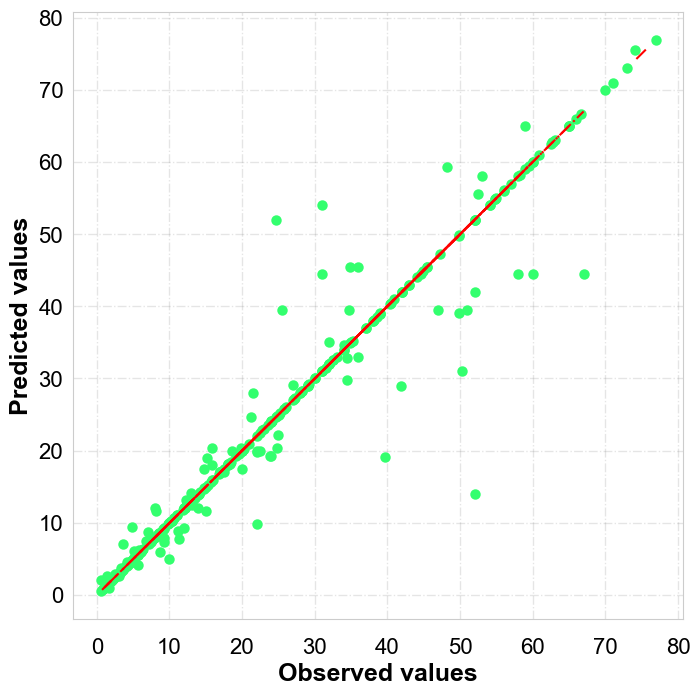

c:\Users\Nilson\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


🎯Modelo: Neural Network 64 64 
 r^2 acurácia treino: 71.523 
 r^2 acurácia teste: 66.715 



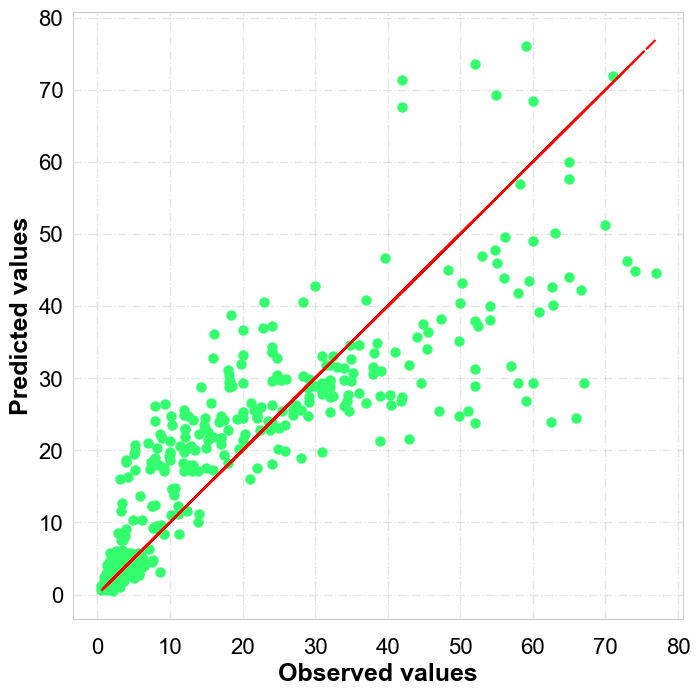

c:\Users\Nilson\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


🎯Modelo: Neural Network 128 128 64 
 r^2 acurácia treino: 87.225 
 r^2 acurácia teste: 77.956 



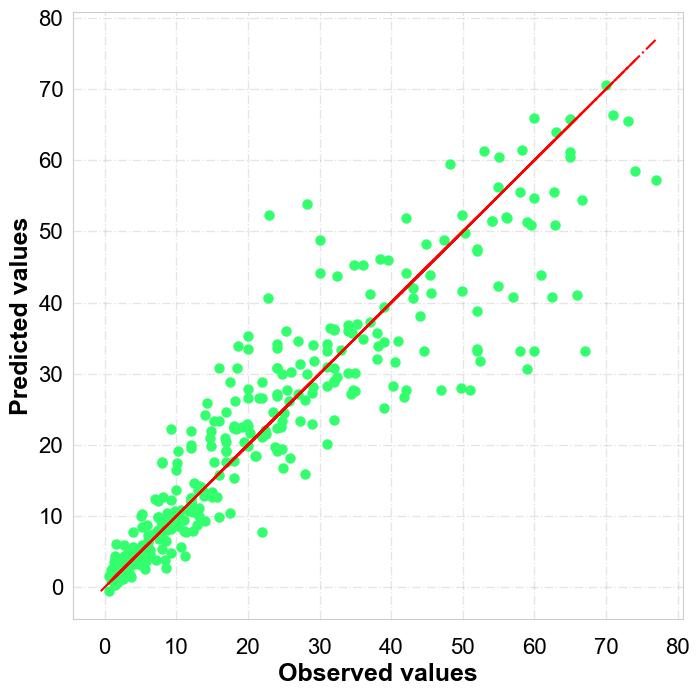

🎯Modelo: Neural Network 128 128 64 sgd 
 r^2 acurácia treino: 89.963 
 r^2 acurácia teste: 73.505 



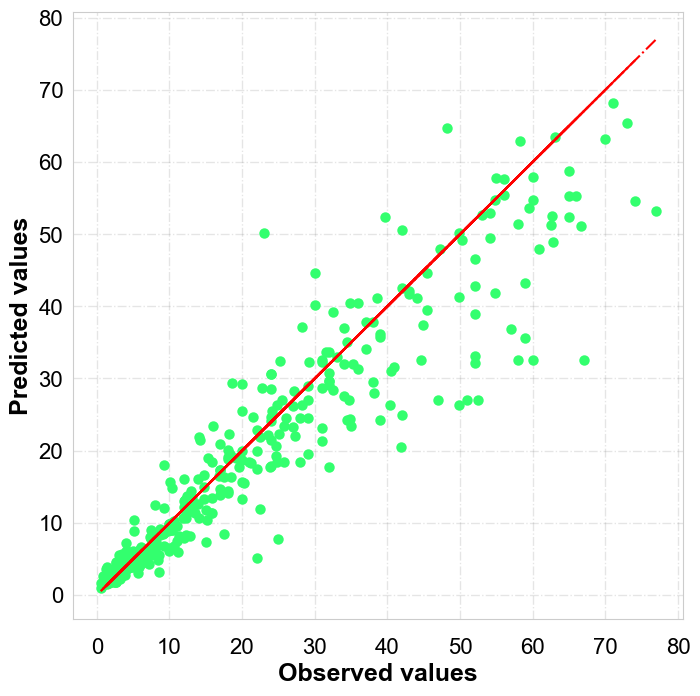

c:\Users\Nilson\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


🎯Modelo: Neural Network 64 64 sgd 
 r^2 acurácia treino: 89.467 
 r^2 acurácia teste: 76.029 



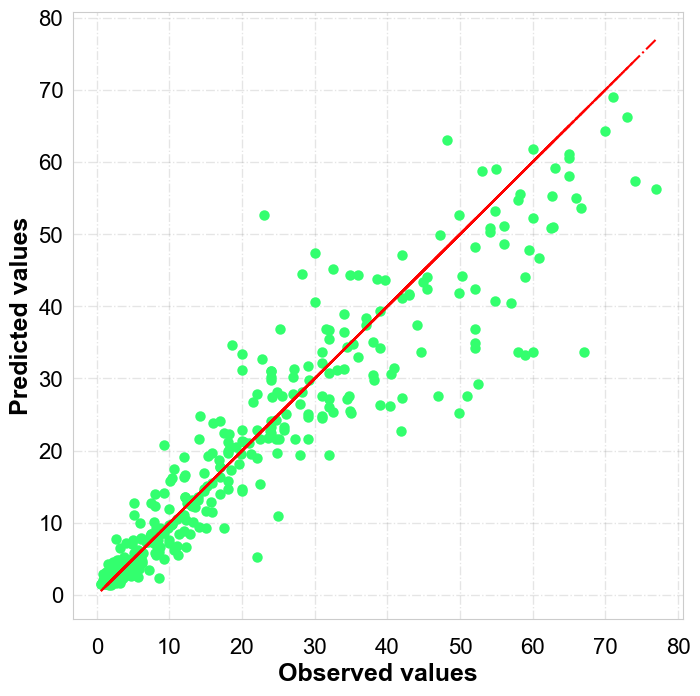

c:\Users\Nilson\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


🎯Modelo: Neural Network 128 64 32 
 r^2 acurácia treino: 84.574 
 r^2 acurácia teste: 76.213 



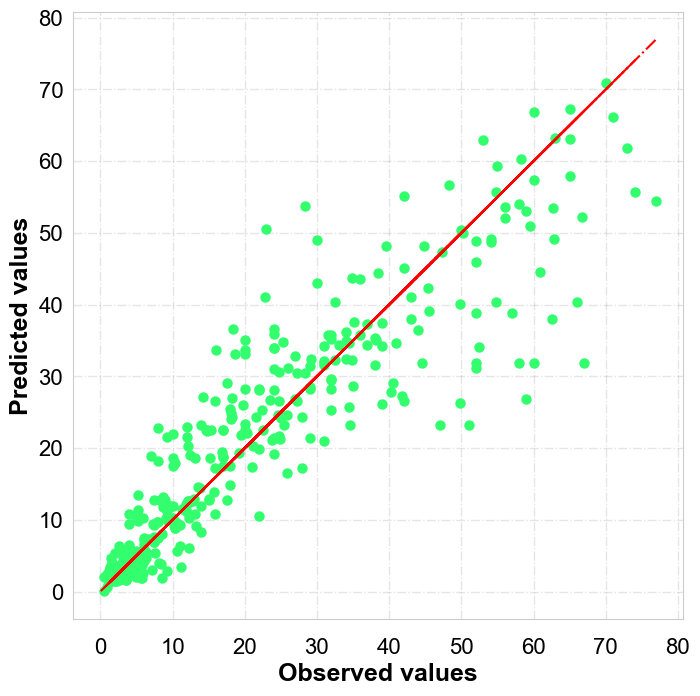

🎯Modelo: Neural Network 128 64 32 sgd 
 r^2 acurácia treino: 89.614 
 r^2 acurácia teste: 77.967 



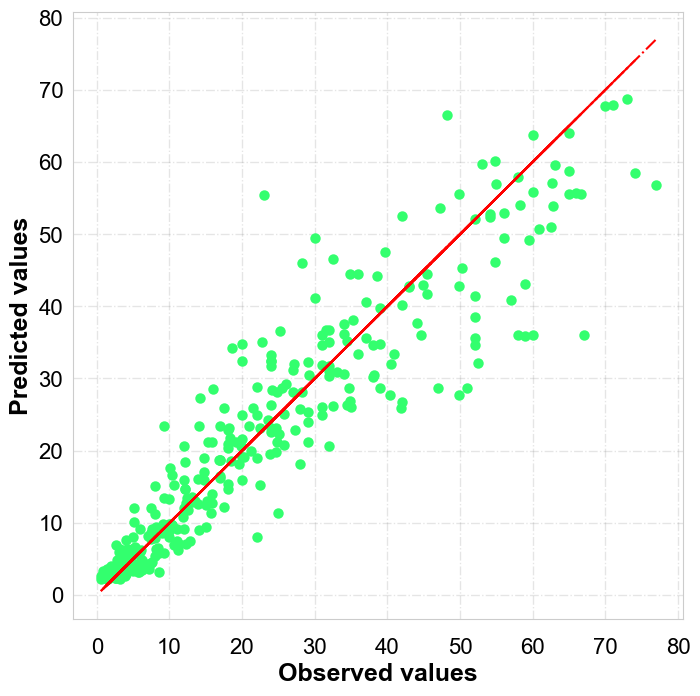

In [35]:
# Treino / teste
%run scatter_predicao.ipynb
#for J_CONT in range(1):
for J_CONT in range(len(MODELOS)):
    # Carregando o modelo
    MODELO = MODELOS[J_CONT][0]
    if (MODELOS[J_CONT][5] == 'Regressão' or MODELOS[J_CONT][5] == 'Regression'):
        GRAU_POLI = MODELOS[J_CONT][6]
        PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
    else:
        PIPELINE = MODELO
        
    # Treinamento
    PIPELINE.fit(X_TREINO, Y_TREINO)
        
    # Acurácia do treino
    Y_PREDTREINO = PIPELINE.predict(X_TREINO)
    R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)
        
    # Acurácia do teste
    Y_PREDTESTE = PIPELINE.predict(X_TESTE)
    R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)
       
    # Armazenando os resultados
    MODELOS[J_CONT][3] = R2_TREINO
    MODELOS[J_CONT][4] = R2_TESTE
        
    # Impressões no console
    print('\U0001F3AF' + 'Modelo: ' + MODELOS[J_CONT][1] + ' \n ' + 'r^2 acurácia treino: %.3f \n r^2 acurácia teste: %.3f' % (R2_TREINO * 100, R2_TESTE * 100), '\n')
    
    # ScatterPlot
    Y_NUM = PIPELINE.predict(X)
    DATASET = {'X': Y.values.ravel().tolist(), 'Y': Y_NUM.tolist()}

    PLOT_SETUP = {
              'NAME': f'scatterplot_modelo_{MODELOS[J_CONT][1]}',
              'WIDTH': 0.20, 
              'HEIGHT': 0.20,
              'DPI': 600, 
              'EXTENSION': '.jpg',
              'MARKER': 'o',
              'MARKER SIZE': 1.5,
              'Y AXIS LABEL': 'Predicted values',
              'X AXIS LABEL': 'Observed values',
              'LABELS SIZE': 16,
              'LABELS COLOR': '#000000',
              'X AXIS SIZE': 18,
              'Y AXIS SIZE': 18,
              'AXISES COLOR': '#000000',
              'ON GRID?': True,
              'LOC LEGEND': 'upper right',
              'SIZE LEGEND': 14,
              'Y LOG': False,
              'X LOG': False,
              'COLOR':"#33FF6E"
             }
    SCATTER_PLOT(DATASET, PLOT_SETUP)


## 1.10 Impressão em planilha dos resultados

In [36]:
RESULTADO_GERAL = pd.DataFrame(MODELOS)
RESULTADO_GERAL.columns = ['modelo', 'obs_1', 'vc', 'treino', 'teste', 'tipologia', 'obs_2']
RESULTADO_GERAL['media'] = (RESULTADO_GERAL['vc'] + RESULTADO_GERAL['teste']) / 2
RESULTADO_GERAL

,modelo,obs_1,vc,treino,teste,tipologia,obs_2,media
0,LinearRegression(),Regressão Linear 1°,4.320005e-01,0.568687,4.905035e-01,Regressão,1,4.612520e-01
1,LinearRegression(),Regressão Não Linear 2°,-1.323933e+00,0.611901,3.189248e-01,Regressão,2,-5.025039e-01
2,LinearRegression(),Regressão Não Linear 3°,-1.234787e+19,0.897000,-4.047128e+18,Regressão,3,-8.197497e+18
3,Ridge(),Regressão Ridge Linear 1°,4.346693e-01,0.568675,4.910279e-01,Regressão,1,4.628486e-01
4,Ridge(),Regressão Ridge Não Linear 2°,3.754715e-01,0.785831,6.840091e-01,Regressão,2,5.297403e-01
5,Ridge(),Regressão Ridge Não Linear 3°,-2.115857e+01,0.865986,7.114910e-01,Regressão,3,-1.022354e+01
6,DecisionTreeRegressor(max_depth=2),Árvore de decisão prof 2,5.478772e-01,0.646536,6.321699e-01,Árvore,2,5.900235e-01
7,DecisionTreeRegressor(max_depth=5),Árvore de decisão prof 5,6.845736e-01,0.858594,7.459482e-01,Árvore,5,7.152609e-01
8,DecisionTreeRegressor(max_depth=10),Árvore de decisão prof 10,7.467656e-01,0.980990,7.317626e-01,Árvore,10,7.392641e-01
9,DecisionTreeRegressor(max_depth=20),Árvore de decisão prof 20,7.454831e-01,0.992004,7.350971e-01,Árvore,20,7.402901e-01


## 1.11 Salvando o melhor modelo

### 1.11.1 Salvando o modelo de IA

Foi considerada como referência para salvar o modelo o desempenho médio da validação cruzada e do teste.

In [44]:
INDEX_MELHOR = RESULTADO_GERAL.index[RESULTADO_GERAL['media'] == RESULTADO_GERAL['media'].max()].tolist()[0]
print(INDEX_MELHOR)
MELHOR_MODELO = MODELOS[INDEX_MELHOR]
MELHOR_MODELO


11


[GradientBoostingRegressor(max_depth=10, n_estimators=50),
 'Gradiente Boosting 50 10',
 0.7819749114040581,
 0.9919270103366837,
 0.8080801158592894,
 'Ensemble',
 50]

A extensão do arquivo SAV é mais comumente conhecido como uma extensão genérico que é usado para salvar arquivos e dados"

In [45]:
CONCRETE_MODELO = "model.sav"
pickle.dump(MELHOR_MODELO, open(CONCRETE_MODELO, 'wb'))


### 1.11.2 Salvando a escala do modelo de IA

In [46]:
nome_arquivo = "scale.sav"
pickle.dump(ESCALAS, open(nome_arquivo, 'wb'))

In [47]:
MELHOR_MODELO[0]

GradientBoostingRegressor(max_depth=10, n_estimators=50)

In [73]:
import joblib
from sklearn.pipeline import make_pipeline
#PIPELINE = make_pipeline(PolynomialFeatures(degree = 2), MELHOR_MODELO[0])
MODELO = MELHOR_MODELO[0]
if (MODELOS[J_CONT][5] == 'Regressão' or MODELOS[J_CONT][5] == 'Regression'):
    GRAU_POLI = MODELOS[J_CONT][6]
    PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
else:
    PIPELINE = MODELO
        
# Treinamento
PIPELINE.fit(X_TREINO, Y_TREINO)

# Acurácia do treino
Y_PREDTREINO = PIPELINE.predict(X_TREINO)
R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)
        
# Acurácia do teste
Y_PREDTESTE = PIPELINE.predict(X_TESTE)
R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)
#print(R2_TESTE)
#print(R2_TREINO)
#joblib.dump(PIPELINE, 'melhor_modelo.pkl')
import pickle
with open('melhor_modelo.pkl', 'wb') as file:
    pickle.dump(PIPELINE, file)

print("R2 treino = ",R2_TREINO)
print("R2 teste = ", R2_TESTE)


R2 treino =  0.9919270103366837
R2 teste =  0.8128715298666234


In [71]:


# Carregar o modelo salvo
with open('melhor_modelo.pkl', 'rb') as file:
    modelo_carregado = pickle.load(file)
print(type(modelo_carregado))


<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


### 1.11.3 Testando o modelo salvo

In [1]:
from sklearn.metrics import r2_score
# Carregar o modelo salvo
with open('melhor_modelo.pkl', 'rb') as file:
    modelo_carregado = pickle.load(file)
print(type(modelo_carregado))

Y_PREDTREINO =  modelo_carregado.predict(X_TESTE)
R2_TREINO = r2_score(Y_TESTE, Y_PREDTREINO)
R2_TREINO

NameError: name 'pickle' is not defined